# Model discrepancy example: The ball-drop experiment

A ball is dropped from a tower of height $h_0$ at initial time $t_0=0$ with intial velocity $v_0=0$. The height from the ground is recorded at discrete time points. Data is generated based on a model with drag, and includes uncorrelated Gaussian measurement errors. The aim is to extract the value of accelaration due to gravity, $g$.

The problem is that the data is noisy *and* our theoretical model, which is simply free fall without drag, is incorrect. How can we best formulate our analysis such that the extraction of $g$ is robust? I.e., that we get a distribution for $g$ that covers the true answer with plausible uncertainty.

**This notebook was created by Dr. Sunil Jaiswal in July, 2025.**

## Statistical formulation

We will follow the article by [Higdon et.al.](https://epubs.siam.org/doi/10.1137/S1064827503426693)
The statistical equation accounting for model discrepancy is:

\begin{equation*}
    y(x_i) = \eta(x_i; {\boldsymbol \theta}) + \delta(x_i;{\boldsymbol \phi}) + \epsilon(x_i;{\boldsymbol \sigma_{\boldsymbol \epsilon}}) \,, \quad i =1, \dots , n
\tag{1}
\end{equation*}

where $x$ is the input vector (time in the case of the ball drop experiment) of length $n$. 
* We shall denote the input domain as $\{x_1,\cdots,x_n\}\in \chi_*$.
* The above equation should be understood as an equation which holds on the range (set of all possible outcomes) of the probability distributions. It means that a sample drawn at a given $x_i$ from the probability distributions $\mathrm{pr}(y)$ should be equal to the sum of the sample drawn from each of the distributions $\mathrm{pr}(\eta|{\boldsymbol \theta})$, $\mathrm{pr}(\delta|{\boldsymbol \phi})$ and $\mathrm{pr}(\epsilon|{\boldsymbol \sigma_{\boldsymbol \epsilon}})$.
* Note that for given $x_i$, $\mathrm{pr}(\eta(x_i)|{\boldsymbol \theta}) = \delta(\eta(x_i)-\eta(x_i;{\boldsymbol \theta}))$ is deterministic since the model is deterministic given ${\boldsymbol \theta}$ (note: $\delta$ is the Dirac delta function).


In Eq. (1), $y(x_i)$ are vectors of the measured observables (velocity and height) at each input point $x_i$. 
* The error in the measurement of $y(x_i)$ is represented by $\epsilon(x_i;{\boldsymbol \sigma_{\boldsymbol \epsilon}})$, which is assumed to be independently and identically distributed $\sim N(0, {\boldsymbol \sigma_{\boldsymbol \epsilon}}^2)$ for each type of observable (velocity and height: $\{\sigma_v, \sigma_h\} \in {\boldsymbol \sigma_{\boldsymbol \epsilon}}$).
* Note that $\{\sigma_v, \sigma_h\}$ are fixed constants since we have assumed the distribution for each type of observable to be iid's. We shall treat them as information `$I$' whenever we write any probability distribution $\mathrm{pr}(\bullet|\bullet,I)$, and will not state them explicitly.
* $\eta(x;{\boldsymbol \theta})$ denotes the observable predictions of the physics theory given the value of the parameters of the theory $\{g, \sigma_{v_0}\}\in {\boldsymbol \theta}$.
* The stochastic model $\mathrm{pr}(\delta(x)|{\boldsymbol \phi}) = GP[0,\kappa(x, x';{\boldsymbol \phi})]$, accounts for model discrepancy (discrepancy between the physics model and reality) where $\kappa$ is covariance kernel of the Gaussian Process (GP) with  $\{\bar{c}_v,\, l_v,\, \bar{c}_h,\, l_h\}\in {\boldsymbol \phi}$ representing the hyperparameters.
* We define   $\{{\boldsymbol \theta}, {\boldsymbol \phi}\} \in {\boldsymbol \alpha}$ as a vector containing ${\boldsymbol \theta}$ and ${\boldsymbol \phi}$ for compact notation.


## Theory

Consider the drag force on the ball (sphere) for the true model to behave as

\begin{equation*}
{\bf f}_D = -(b v + c v^2)\, \hat{\bf{v}} \,, \tag{2}
\end{equation*}

<!-- $${\bf f}_D = -(b v + c v^2)\, \hat{\bf{v}} \,, \tag(2)$$ -->
where $v$ is magnitude of velocity $\bf{v}$.
The coefficients $b$ and $c$ are drag coefficients.

$\bullet$ Equation of motion: 

$$m\frac{d\bf{v}}{dt} = m {\bf g} - b {\bf v}- c v^2 \hat{\bf{v}} \,.$$ 

We have considerd the downward direction to be positive. Here $\color{red}{m=1\, kg}$ is the mass of the sphere and $\color{red}{g=9.8\, m/s^2}$ the acceleration due to gravity. 


$\bullet$ The equation for velocity can be written as $m\frac{d v}{dt} = m g - b v- c v \sqrt{v^2}$. The last term is written such that it takes into account the direction of velocity in quadratic term. We need to solve the equations:

$$\frac{d v}{dt} = g - \frac{b}{m} v- \frac{c}{m} v |v| \,, \qquad 
\frac{dh}{dt} = -v \,.$$

By default we consider the ball to have the initial height $\color{red}{h_0=60\, m}$ at initial time $\color{red}{t_0=0\,sec}$ with initial velocity $\color{red}{v_0=0\, m/s^2}$.

### Set plot style

In [1]:
import matplotlib.pyplot as plt

# # Add the local CodeLocal directory to the path so Jupyter finds the module file.
# import sys
# sys.path.append('./CodeLocal')
# from setup_rc_params import setup_rc_params  # import from setup_rc_params.py in subdirectory CodeLocal

# setup_rc_params(presentation=True, constrained_layout=True, usetex=True, dpi=400)

### Setup sampling with emcee and pocomc samplers

In [2]:
import emcee
import pocomc   # uncomment here when using pocomc sampler
from multiprocess import Pool  
from scipy.stats import uniform
import time
import os

# ================================ emcee sampler ==================================
def emcee_sampling(min_param, max_param, log_posterior, 
                   nburn=2000, nsteps=2000, num_walker_per_dim=8, progress=False):
    """
    Function for sampling in parallel using emcee.
    
    Parameters:
      - min_param (list or array): minimum values parameters
      - max_param (list or array): maximum values parameters
      - log_posterior (callable): log posterior
      - nburn (int): "burn-in" period to let chains stabilize
      - nsteps (int): # number of MCMC steps to take after burn-in
      - num_walker_per_dim (int): number of walker per dimension
      - samples_save_dir (string): directory name in which the samples will be saved
      - progress (boolean): toggle the progress bar
    """
    if len(min_param) != len(max_param):
            raise ValueError(
                f"min_param and max_param must have the same length."
            )

    ndim = len(min_param)  # number of parameters in the model
    nwalkers = ndim * num_walker_per_dim  # number of MCMC walkers
    
    start_time = time.time()
    print(f"Starting MCMC sampling using emcee with {nwalkers} walkers in parallel...")

    # Generate starting guesses within the prior bounds
    starting_guesses =  min_param + (max_param - min_param) * np.random.rand(nwalkers,ndim)
    
    # Create a pool of workers using multiprocessing
    with Pool() as pool:
        # Pass the pool to the sampler
        sampler = emcee.EnsembleSampler(nwalkers,ndim,log_posterior,pool=pool)
    
        # "Burn-in" period
        pos, prob, state = sampler.run_mcmc(starting_guesses, nburn, progress=progress)
        sampler.reset()
    
        # Sampling period
        pos, prob, state = sampler.run_mcmc(pos, nsteps, progress=progress)

    # Collect samples
    samples = sampler.get_chain(flat=True)
    
    end_time = time.time()
    print(f"Sampling complete. Time taken: {(end_time - start_time)/60:.2f} minutes.")
    print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f} (in total {nwalkers*nsteps} steps)")
    print(f"Samples shape: {samples.shape}")

    return samples


# ================================ pocoMC sampler ==================================
def pocomc_sampling(min_param, max_param, log_posterior,
                    n_effective=2000, n_active=800, n_steps=None,
                    # n_prior=2048, n_max_steps=200, 
                    n_total=5000, n_evidence=5000, ncores = -1
                   ):
    """
    This function is based on PocoMC package (version 1.2.1).
    pocoMC is a Preconditioned Monte Carlo (PMC) sampler that uses 
    normalizing flows to precondition the target distribution.

    Parameters:
      - min_param (list or array): Minimum values parameters
      - max_param (list or array): Maximum values parameters
      - log_posterior (callable): Log posterior

      - n_effective (int): The effective sample size maintained during the run. Default: 2000.
      - n_active (int): Number of active particles. Default: 800. Must be < n_effective.
      - n_steps (int): Number of MCMC steps after logP plateau. Default: None -> n_steps=n_dim. 
                       Higher values lead to better exploration but increases computational cost.
      - n_total (int): Total effectively independent samples to be collected. Default: 5000.
      - n_evidence (int): Number of importance samples used to estimate evidence. Default: 5000. 
                          If 0, the evidence is not estimated using importance sampling.

      - ncores: Number of cores to use in sampling. 
                  -1 (default): use all availaible cores
                   n (int): use n cores
    """

    # Generating prior range for pocomc
    priors = [uniform(lower, upper - lower) for lower, upper in zip(min_param, max_param)]
    prior = pocomc.Prior(priors)
    
    ndim = len(min_param)  # number of parameters in the model

    # -------------------------------------------------------------------------------------------- 
    # Try to get the allowed CPU count via affinity (works on Linux/Windows)
    try:
        available_cores = len(os.sched_getaffinity(0))# len(psutil.Process().cpu_affinity())
    except Exception:
        # On systems where affinity is not available (e.g., macOS), use total CPU count
        available_cores = os.cpu_count()

    # Validate that ncores is an integer and at least -1
    if not isinstance(ncores, int) or ncores < -1:
        raise ValueError("ncores must be an integer greater than or equal to -1. Specify '-1' to use all available cores.")
    
    if ncores == -1:
        # Use all available cores
        num_cores = available_cores
    elif ncores > available_cores:
        # Warn if more cores are requested than available and then use available cores
        warnings.warn(
            f"ncores ({ncores}) exceeds available cores ({available_cores}). Using available cores.",
            UserWarning
        )
        num_cores = available_cores
    else:
        num_cores = ncores     
    # --------------------------------------------------------------------------------------------
    
    start_time = time.time()

    sampler = pocomc.Sampler(prior=prior, likelihood=log_posterior,
                                 n_effective=n_effective, n_active=n_active, n_steps=n_steps,
                                 # dynamic=True, n_prior=n_prior, n_max_steps=n_max_steps,
                                 pytorch_threads=None,  # use all availaible threads for training
                                 pool=num_cores
                                 )

    print(f"Starting sampling using pocomc in {num_cores} cores...")

    sampler.run(n_total=n_total, 
                n_evidence=n_evidence, 
                progress=True)


    # Generating the posterior samples
    # samples, weights, logl, logp = sampler.posterior() # Weighted posterior samples
    samples, _, _ = sampler.posterior(resample=True)  # equal weights for samples 
    
    # Generating the evidence
    # logz, logz_err = sampler.evidence() # Bayesian model evidence estimate and uncertainty
    # print("Log evidence: ", logz)
    # print("Log evidence error: ", logz_err)
    
    # logging.info('Writing pocoMC chains to file...')
    # chain_data = {'chain': samples, 'weights': weights, 'logl': logl,
    #                 'logp': logp, 'logz': logz, 'logz_err': logz_err}

    end_time = time.time()
    print(f"Sampling complete. Time taken: {(end_time - start_time)/60:.2f} minutes.")
    print(f"Samples shape: {samples.shape}")
        
    return samples


### Generate "experimental" observations for height

In [3]:
import numpy as np
from scipy.integrate import odeint

def True_height(t, h0=60.0, v0=0.0,
                g=9.8, m=1.0, b=0.0, c=0.4):    # initial conditions
    """
    Height of a falling ball with linear + quadratic air drag.

    Parameters
    ----------
    t : float or 1-D array_like
        Time(s) at which to evaluate the height.
    h0, v0 : float, optional
        Initial height and velocity at time t = 0.
    g : float, optional
        Acceleration due to gravity (m s⁻²) (taken positive downward).
    m : float, optional
        Mass of the ball (kg).
    b, c : float, optional
        Linear and quadratic drag coefficients.

    Returns
    -------
    h : 1darray
        Height(s) at the requested time points (same shape as `t`).
    """

    def derivatives(y, _t):
        h, v = y
        dhdt = -v
        dvdt = g - (b*v)/m - (c*abs(v)*v)/m
        return [dhdt, dvdt]

    # Ensure we integrate from t0 out to the requested time(s)
    t = np.atleast_1d(t)
    times = np.concatenate(([t[0]], t))  # add t[0] to get solution at t=0 
    sol = odeint(derivatives, [h0, v0], times)
    
    return sol[1:, 0]

In [4]:
np.random.seed(42)  # Set a random seed for reproducibility. Change 42 -> 0 for different seeds every time.

# Generate an array of time where height are observed -->
t_obs = np.linspace(0.0, 1.0, 10)
t_noise = np.random.uniform(1e-3, 1e-2, size = t_obs.shape)  # random noise added to time. helps in inversion of covariance matrix.
t_noise[0] = 0.0  # No noise for initial time
t_obs = np.round(t_obs + t_noise, decimals=4)


# Compute height of ball at these time steps -->
hexp_std = 0.1 # standard deviation of assumed gaussian noise as error of measurment
hexp_err = np.array([hexp_std]*len(t_obs))  # adding gaussian noise to observation of height
hexp_mean = np.random.normal(True_height(t_obs), hexp_err)    # observed height at input times


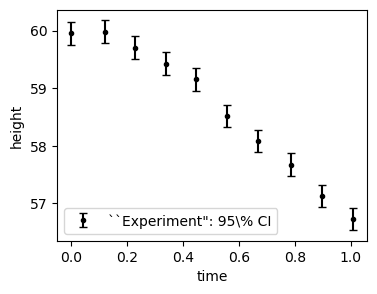

In [5]:
plt.figure(figsize=(4, 3)) 
plt.errorbar(t_obs, hexp_mean, yerr=[1.96*hexp_err, 1.96*hexp_err], 
             fmt='o', markersize=3, capsize=3, color='black', 
             label=f'``Experiment": 95\% CI')
plt.ylabel('height')
plt.xlabel('time')
plt.legend()

plt.show()

## Define physics model

In [6]:
def model_height(t, g, v0=0.0, h0=60.0):
    return np.atleast_1d(h0  - v0 * t - g * t**2 / 2.0 )

# def model_height(t, g, v0, h0=60.0):
#     f = True_height(t, h0=60.0, v0=v0, g=g, m=1.0, b=0.0, c=0.0)
#     return np.atleast_1d(f)
# model_height(t=t_obs, g = 9.8)

## Define model discrepancy class

In [7]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis

class ModelDiscrepancy():
    def __init__(self, t_obs, hexp_mean, hexp_err, model_height, num_model_param, log_priors, MD = False, kernel_func = None):

        self.t_obs = t_obs
        self.hexp_mean = hexp_mean
        self.hexp_err = hexp_err
        self.model_height = model_height
        self.num_model_param = num_model_param
        self.log_priors = log_priors
        self.MD = MD
        self.kernel_func = kernel_func

        if self.MD:
            self.log_priors_model = self.log_priors[:self.num_model_param]
            self.log_priors_MDGP = self.log_priors[self.num_model_param:]
        else:
            self.log_priors_model = self.log_priors
        
        # standardize experimental data  ----->
        self.scaler = StandardScaler()
        self.hexp_mean_scaled = self.scaler.fit_transform(self.hexp_mean.reshape(-1, 1)).ravel()
        
        self.offset = float(self.scaler.mean_[0])
        self.scale = float(self.scaler.scale_[0])
        
        self.hexp_err_scaled = self.hexp_err / self.scale
    #=======================================================================
    
    def log_likelihood(self, theta, phi=[]):
        """
        Calculate the log-likelihood of a dataset given the mean and covariance matrix.
    
        Parameters:
            theta: 1D NumPy array containing model parameters.
            phi: 1D NumPy array containing GP kernel hyperparameters.
    
        Returns:
            Log-likelihood of the dataset.
        """
    
        if self.num_model_param == 1:
            g = theta[0]
            h = model_height(t = self.t_obs, g = g)
        elif self.num_model_param == 2:
            g, v0 = theta[0], theta[1]
            h = self.model_height(t = self.t_obs, g = g, v0 = v0)
    
        hmodel_scaled = (h - self.offset) / self.scale
    
        cov_exp = np.diag(self.hexp_err_scaled**2)
        
        if self.MD == False:
            cov_total = cov_exp
        else:
            X = self.t_obs.reshape(-1, 1)
            cov_total = self.kernel_func(X, X, *phi) + cov_exp
                                
        k = len(self.t_obs)  # number of observables
    
        md2 = mahalanobis(self.hexp_mean_scaled, hmodel_scaled, np.linalg.inv(cov_total))**2
    
        # calculate the log-likelihood
        log_likelihood_value = -0.5 * (md2 + np.log(np.linalg.det(cov_total)) + k * np.log(2.0 * np.pi) )
                                    
        return log_likelihood_value
    #=======================================================================
    
    def log_posterior(self, theta_and_phi):
        """
        Calculate the log posterior = sum of log priors + log likelihood.
    
        Parameters
        ----------
        theta_and_phi : np.ndarray (1D)
            Combined array of model params (theta) and discrepancy params (phi) if MD=True.
    
        Returns
        -------
        float
            The log posterior value.
        """
        theta_and_phi = np.atleast_1d(theta_and_phi)
        
        if self.MD:
            theta = theta_and_phi[:self.num_model_param]
            phi = theta_and_phi[self.num_model_param:]

        else:
            theta = theta_and_phi
            phi = []

        # ----------------------------------------
        # Calculate log-prior for model parameters
        # ----------------------------------------
        log_prior_val = 0.0
        for i, prior_func in enumerate(self.log_priors_model):
            lp = prior_func(theta[i])
            if lp <= -1e5:
                return -1e30
            log_prior_val += lp

        # ------------------------------------------------------
        # If MD ==True, accumulate log-prior for phi as well
        # ------------------------------------------------------
        if self.MD:
            for i, prior_func in enumerate(self.log_priors_MDGP):
                lp = prior_func(phi[i])
                if lp <= -1e5:
                    return -1e30
                log_prior_val += lp

        # ------------------------
        # Calculate log-likelihood
        # ------------------------
        log_likelihood_val = self.log_likelihood(theta, phi)

        return log_prior_val + log_likelihood_val

## Define priors

In [8]:
from scipy.stats import beta

# Define function for general beta priors 
def log_prior_param(param, alpha_val, beta_val, param_min, param_max):
    """
    Log prior for parameter based on a Beta distribution.
    """
    scale = param_max - param_min  # Rescaling factor

    if param_min < param < param_max:
        # Rescale param to the range [param_min, param_max]
        param_rescaled = (param - param_min) / scale
        
        prior = beta.pdf(param_rescaled, alpha_val, beta_val) / scale
        return np.log(prior)
    else:
        return -np.inf



In [9]:
model_param_bounds = np.array([[ 0.0,  20.0 ],
                               [-2.0 ,  2.0 ]])

# model_param_bounds = np.array([[ 0.0,  20.0 ]])  # When only model parameter is g -- That's all the change required in code

num_model_param = len(model_param_bounds)

# Define a list of log_prior functions for model parameters
log_prior_theta = [
    lambda param, i=i: log_prior_param(
        param, alpha_val=1.01, beta_val=1.01,  # for flat priors
        param_min=model_param_bounds[i][0], param_max=model_param_bounds[i][1]
    )
    for i in range(num_model_param)
]

## Without model discrepancy

In [10]:
# Instantiate class  -->
MDC = ModelDiscrepancy(t_obs=t_obs, hexp_mean=hexp_mean, hexp_err=hexp_err, 
                      model_height=model_height, num_model_param=num_model_param, 
                      log_priors=log_prior_theta, MD = False, kernel_func = None)


In [11]:
from scipy import optimize

guess = model_param_bounds.mean(axis=1)

# Find Maximum likelihood value for parameters -->
nll = lambda *args: - MDC.log_likelihood(*args)
result = optimize.minimize(nll, guess,  method = 'Powell')
max_lik = result['x']
print(result)
print("\nMaximum likelihood value for parameters:", max_lik,"\n")


# Find MAP values for parameters -->
nlp = lambda *args: - MDC.log_posterior(*args)
result = optimize.minimize(nlp, guess,  method = 'Powell')
MAP = result['x']
print(result)
print("\nMAP values for parameters:", MAP)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 1
     fun: -8.556378888999681
       x: [ 3.977e+00  1.354e+00]
     nit: 83
   direc: [[ 7.342e-03  7.656e-05]
           [ 9.371e-03 -8.352e-04]]
    nfev: 2000

Maximum likelihood value for parameters: [3.97682437 1.35379069] 

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 1
     fun: -4.17801963736677
       x: [ 3.978e+00  1.353e+00]
     nit: 83
   direc: [[ 7.276e-03  1.052e-04]
           [ 9.307e-03 -8.065e-04]]
    nfev: 2000

MAP values for parameters: [3.97794526 1.35323281]


In [12]:
import corner

min_param = model_param_bounds[:,0]
max_param = model_param_bounds[:,1]
lab = [r'$g$', r'$v_0$']

### Now do the sampling and plot the posteriors

Starting MCMC sampling using emcee with 16 walkers in parallel...
Sampling complete. Time taken: 0.07 minutes.
Mean acceptance fraction: 0.714 (in total 1600 steps)
Samples shape: (1600, 2)


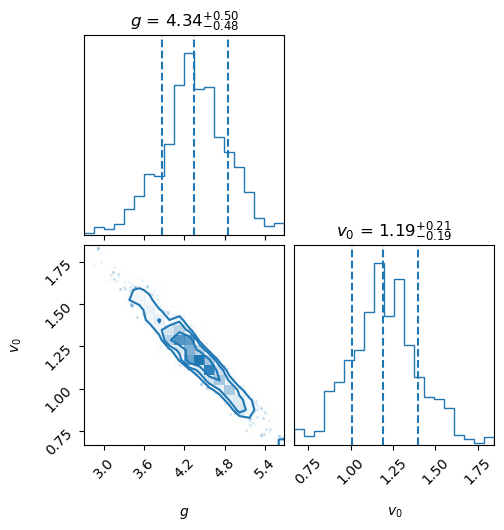

In [13]:
num_burn = 100  # 2000 is a minimum
num_steps = 100  # 2000 is a minimum

samples_WMD = emcee_sampling(min_param = min_param, max_param = max_param, 
                         log_posterior = MDC.log_posterior, 
                         nburn = num_burn, nsteps = num_steps, num_walker_per_dim = 8)

fig = corner.corner(samples_WMD, labels=lab, color='C0', quantiles=[0.16, 0.5, 0.84],
                   show_titles=True, title_kwargs={"fontsize": 12}, hist_kwargs={'density': True})
plt.show()

In [14]:
# # sampling with pocomc for consistency check ---> 

# n_effective_mltpl = 500
# n_active_mltpl = 150  # 0.3 x n_eff
# n_steps_mltpl = 2
# num_param = len(min_param)

# n_effective = n_effective_mltpl * num_param
# n_active = n_active_mltpl * num_param
# n_steps = n_steps_mltpl * num_param
# # print(n_effective, n_active, n_steps)

# n_total = 20000

# samples_WMD_poco = pocomc_sampling(min_param, max_param, MDC.log_posterior,
#                                   n_effective=n_effective, n_active=n_effective, n_steps=n_steps,
#                                   n_total=n_total, n_evidence=n_total)

# fig = corner.corner(samples_WMD_poco, labels=lab, color='C0', quantiles=[0.16, 0.5, 0.84],
#                    show_titles=True, title_kwargs={"fontsize": 12}, hist_kwargs={'density': True})
# plt.show()

## With model discrepancy

In [15]:
from sklearn.gaussian_process.kernels import DotProduct, RBF

def MD_kernel(X1, X2, cbar, l, r, s):
    """
    Compute the covariance matrix using a custom kernel:
    K(X1, X2) = s^2 + cbar^2 * (X1 @ X2.T)^r * exp(-||X1 - X2||^2 / (2 * l^2)).

    This kernel serves as the core of the Model Discrepancy framework and should be modified
    to suit specific problems.

    Parameters:
        - X1 (numpy.ndarray): A matrix where each row represents an input vector.
        - X2 (numpy.ndarray): A matrix where each row represents an input vector.
        - cbar (float): The marginal variance parameter.
        - l (float): The length scale parameter for the RBF term.
        - r (float): The power applied to the dot product term.
        - s (float): A constant shift.

    Returns:
        - numpy.ndarray: A covariance matrix computed using the defined kernel.
    """
    # Compute the dot product term
    dot_product_term = np.dot(X1, X2.T) ** r if r > 0 else 1.0

    # Compute the RBF kernel term
    rbf_kernel = RBF(length_scale=l)
    rbf_term = rbf_kernel(X1, X2)

    # Combine terms
    cov_matrix =  s**2 + cbar**2 * dot_product_term * rbf_term
    return cov_matrix
    
# ===========================================================================================

In [16]:
# Define hyperparameter bounds and priors 
HP_bounds = np.array([[ 0.0,  10.0 ],     # for cbar
                      [ 0.0 ,  10.0 ],    # for l
                      [ 0.0 ,  10.0 ]     # for r
                      # [ 0.0 ,  10.0 ]   # for s
                     ])  

# Define priors for GP hyperparmeters
log_prior_cbar = lambda param: log_prior_param(param, alpha_val=1.01, beta_val=1.01, param_min=HP_bounds[0][0], param_max=HP_bounds[0][1])
log_prior_l =    lambda param: log_prior_param(param, alpha_val=1.01, beta_val=1.01, param_min=HP_bounds[1][0], param_max=HP_bounds[1][1])
log_prior_r =    lambda param: log_prior_param(param, alpha_val=1.01, beta_val=1.01, param_min=HP_bounds[2][0], param_max=HP_bounds[2][1])
# log_prior_s =    lambda param: log_prior_param(param, alpha_val=1.01, beta_val=1.01, param_min=HP_bounds[3][0], param_max=HP_bounds[3][1])

In [17]:
kernel = lambda X1, X2, cbar, l, r: MD_kernel(X1, X2, cbar, l, r, s=0)
log_prior_phi = [log_prior_cbar, log_prior_l, log_prior_r]

log_priors_thetaphi = np.concatenate([log_prior_theta, log_prior_phi])
param_bounds = np.concatenate([model_param_bounds, HP_bounds])

# Instantiate class  -->
MDC = ModelDiscrepancy(t_obs=t_obs, hexp_mean=hexp_mean, hexp_err=hexp_err, 
                      model_height=model_height, num_model_param=num_model_param, 
                      log_priors=log_priors_thetaphi, MD = True, kernel_func = kernel)

In [18]:
from scipy import optimize

# Find MAP values for parameters -->
guess = param_bounds.mean(axis=1)

nlp = lambda *args: - MDC.log_posterior(*args)
result = optimize.minimize(nlp, guess,  method = 'Powell')
MAP = result['x']

print(result)
print("\nMAP values for parameters:", MAP)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.130478145440673
       x: [ 6.949e+00  5.352e-01  6.789e-01  6.310e+00  6.134e+00]
     nit: 11
   direc: [[-7.990e-01  1.626e-01 ... -6.852e-01  5.009e-01]
           [ 3.777e-02  3.153e-02 ...  3.087e-01 -1.696e-01]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-3.678e-01  6.470e-02 ... -4.417e-01  8.013e-01]]
    nfev: 583

MAP values for parameters: [6.94940459 0.53522913 0.67887983 6.30979757 6.13444589]


In [19]:
import corner

min_param = param_bounds[:,0]
max_param = param_bounds[:,1]
lab = [r'$g$', r'$v_0$', r'$\bar{c}$', r'$\ell$', r'$r$', r'$s$']

Starting MCMC sampling using emcee with 40 walkers in parallel...
Sampling complete. Time taken: 0.20 minutes.
Mean acceptance fraction: 0.355 (in total 4000 steps)
Samples shape: (4000, 5)


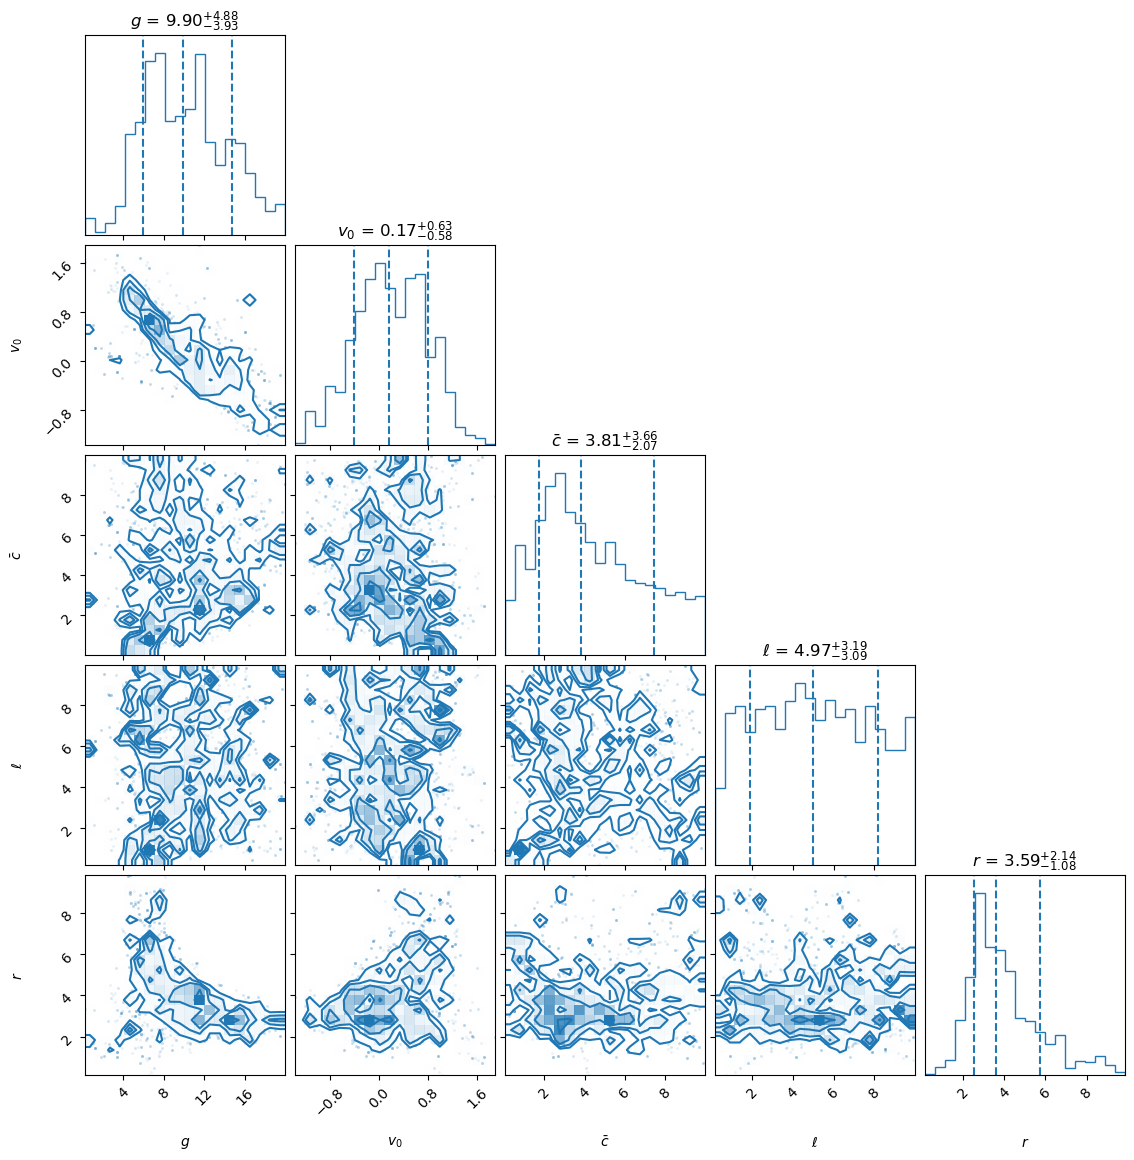

In [20]:
num_burn = 100  # 2000 is a minimum
num_steps = 100  # 2000 is a minimum

samples_MD = emcee_sampling(min_param = min_param, max_param = max_param, 
                         log_posterior = MDC.log_posterior, 
                         nburn = num_burn, nsteps = num_steps, num_walker_per_dim = 8)

fig = corner.corner(samples_MD, labels=lab, color='C0', quantiles=[0.16, 0.5, 0.84],
                   show_titles=True, title_kwargs={"fontsize": 12}, hist_kwargs={'density': True})
plt.show()

In [21]:
# # sampling with pocomc for consistency check ---> 

# n_effective_mltpl = 500
# n_active_mltpl = 150  # 0.3 x n_eff
# n_steps_mltpl = 2
# num_param = len(min_param)

# n_effective = n_effective_mltpl * num_param
# n_active = n_active_mltpl * num_param
# n_steps = n_steps_mltpl * num_param
# # print(n_effective, n_active, n_steps)

# n_total = 20000

# samples_MD_poco = pocomc_sampling(min_param, max_param, MDC.log_posterior,
#                                   n_effective=n_effective, n_active=n_effective, n_steps=n_steps,
#                                   n_total=n_total, n_evidence=n_total)

# fig = corner.corner(samples_MD_poco, labels=lab, color='C0', quantiles=[0.16, 0.5, 0.84],
#                    show_titles=True, title_kwargs={"fontsize": 12}, hist_kwargs={'density': True})
# plt.show()